## ASTR 597A Homework 3
Eric Bellm

Due Jan 24, 2023

Your name:
    
Your collaborators:

In [10]:
# Generic python packages
import numpy as np
import matplotlib.pyplot as plt

# LSST Science Pipelines (Stack) packages
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
import lsst.sphgeom
import lsst.geom as geom

afwDisplay.setDefaultBackend('matplotlib')

# Set a standard figure size to use
plt.rcParams['figure.figsize'] = (8.0, 8.0)

In [11]:
butler = dafButler.Butler('dp02', collections='2.2i/runs/DP0.2')
registry = butler.registry

## Exercise 1: Ask the Butler

The 04b (Intermediate Butler Queries) tutorial notebooks may be helpful.

### Exercise 1a

How many DP0.2 tracts have r-band `'deepCoadd'`s?

In [12]:
# for dt in sorted(registry.queryDatasetTypes()):
#     print(dt)

In [13]:
dt_deepCoadd = registry.getDatasetType('deepCoadd')
print(dt_deepCoadd)

DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF)


In [14]:
import pandas as pd

In [15]:
datasetType = 'deepCoadd'
dataId = {'band': 'r'}
datasetRefs = registry.queryDatasets(datasetType, dataId=dataId)

df = pd.DataFrame([ref.dataId for ref in datasetRefs])
df

,band,skymap,tract,patch
0,r,DC2,3085,17
1,r,DC2,3086,12
2,r,DC2,3084,10
3,r,DC2,3084,32
4,r,DC2,3084,12
...,...,...,...,...
7688,r,DC2,4849,43
7689,r,DC2,4849,40
7690,r,DC2,5062,13
7691,r,DC2,4848,47


In [16]:
len(df['tract'].unique())

157

### Exercise 1b

Find the tract and patch corresponding to (ra, dec) 62.0, -37.0.  If there is more than one r-band `deepCoad` at that position, make a plot that explains why.

In [17]:
my_ra_deg = 62
my_dec_deg = -37
my_filter = 'r'

my_spherePoint = lsst.geom.SpherePoint(my_ra_deg*lsst.geom.degrees, my_dec_deg*lsst.geom.degrees)

skymap = butler.get('skyMap')
tract = skymap.findTract(my_spherePoint)
my_tract = tract.tract_id
my_patch = tract.findPatch(my_spherePoint).getSequentialIndex()
print('My tract and patch: ', my_tract, my_patch)

My tract and patch:  3831 10


In [18]:
level = 23  # the resolution of the HTM grid
pixelization = lsst.sphgeom.HtmPixelization(level)

ra, dec = 62, -37
htm_id = pixelization.index(
    lsst.sphgeom.UnitVector3d(
        lsst.sphgeom.LonLat.fromDegrees(ra, dec)
    )
)

In [19]:
circle = pixelization.triangle(htm_id).getBoundingCircle()
scale = circle.getOpeningAngle().asDegrees()*3600.
level = pixelization.getLevel()
print(f'HTM ID={htm_id} at level={level} is bounded by a circle of radius ~{scale:0.2f} arcsec.')

HTM ID=617345737139805 at level=23 is bounded by a circle of radius ~0.04 arcsec.


In [20]:
datasetRefs = registry.queryDatasets("deepCoadd", htm20=htm_id, dataId=dataId)

for i, ref in enumerate(datasetRefs):
    print(ref)
    if i > 6:
        print('...')
        break

print(f"Found {len(list(datasetRefs))} deepCoadd")

deepCoadd@{band: 'r', skymap: 'DC2', tract: 3831, patch: 3}, sc=ExposureF] (id=4b0c49ef-36ab-4377-b3a9-62cd8ca60e46)
deepCoadd@{band: 'r', skymap: 'DC2', tract: 3831, patch: 10}, sc=ExposureF] (id=76cc103b-03ce-4d32-9829-4ba650271878)
Found 2 deepCoadd


In [21]:
datasetRefs

<DatasetRef iterator for [components of] deepCoadd>

In [22]:
coadds = [butler.get(ref) for ref in datasetRefs]

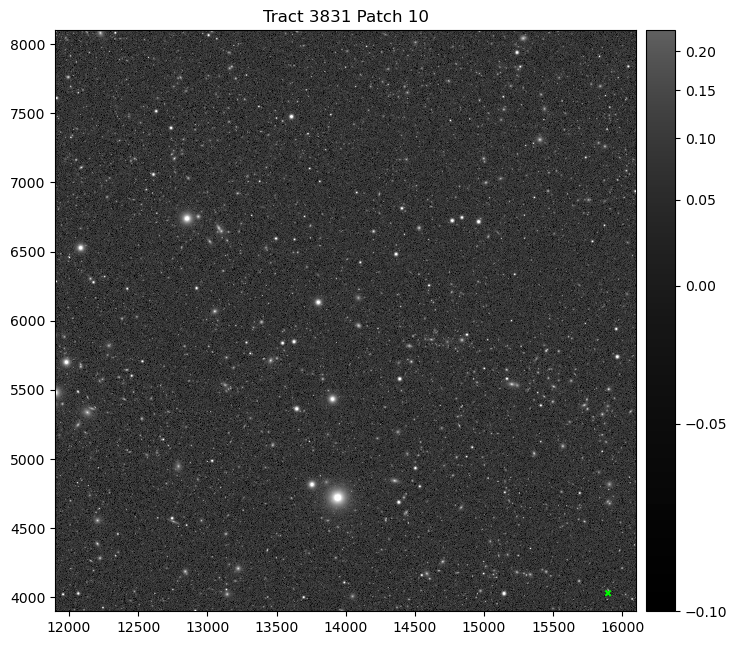

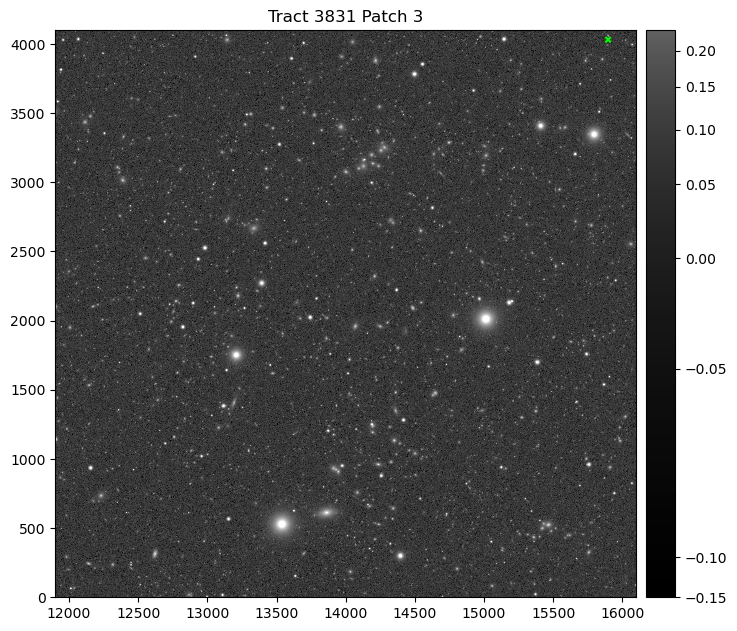

In [46]:
pt = deepCoadd_wcs.skyToPixel(lsst.geom.SpherePoint(62*lsst.geom.degrees, -37*lsst.geom.degrees))
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(coadds[1].image)
display.dot('x', *pt, size=20)
plt.title('Tract 3831 Patch 10')
plt.show() 
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(coadds[0].image)
display.dot('x', *pt, size=20)
plt.title('Tract 3831 Patch 3')
plt.show()

### Exercise 1c

Using the (tract, patch) with the lowest patch number, plot histograms of the seeing values of the images that were coadded in the r-band `deepCoadd` and `goodSeeingCoadd` for that (tract, patch).  Tutorial notebook 09a (Custom Coadd)will give you some ideas on how to get the `coaddInputs`.  The `coaddInputs.ccds` table will be helpful.

For each input `calexp`, you will need to retrieve the PSF and then use `psf.computeShape(psf.getAveragePosition()).getDeterminantRadius()` to get the PSF width in sigma.  Convert these to FWHM in arcseconds for your plots.

In [16]:
coadds[0]

In [17]:
# Retrieve inputs

my_deepCoadd_inputs = coadds[0].getInfo().getCoaddInputs()

In [20]:
deep_inputs = my_deepCoadd_inputs.ccds.asAstropy().to_pandas()

In [49]:
x_target, y_target = 1700, 2100
width, height = 400, 400
xmin, ymin = x_target-width//2, y_target-height//2
point = geom.Point2D(x_target, y_target)

In [50]:
deep_fwhm = []
for ii in deep_inputs.index:
    dataId = {'visit': deep_inputs.loc[ii, 'visit'], 'detector': deep_inputs.loc[ii, 'ccd']}
    calexp = butler.get('calexp', **dataId)
    
    psf = calexp.getPsf()
    sigma = psf.computeShape(point).getDeterminantRadius()
    pixelScale = calexp.getWcs().getPixelScale().asArcseconds()
    deep_fwhm.append(sigma*pixelScale*2.355)

deep_fwhm = np.array(deep_fwhm)

In [48]:
deep_inputs['fwhm'] = deep_fwhm
deep_inputs.to_csv('/home/ykwang1/WORK/astr597-survey-science/data/deepCoaddsInputs.csv', index=False)

NameError: name 'deep_fwhm' is not defined

In [ ]:
good_fwhm = []
for ii in good_inputs.index:
    dataId = {'visit': good_inputs.loc[ii, 'visit'], 'detector': good_inputs.loc[ii, 'ccd']}
    calexp = butler.get('calexp', **dataId)
    
    psf = calexp.getPsf()
    sigma = psf.computeShape(point).getDeterminantRadius()
    pixelScale = calexp.getWcs().getPixelScale().asArcseconds()
    good_fwhm.append(sigma*pixelScale*2.355)

good_fwhm = np.array(good_fwhm)

In [43]:
good_inputs = registry.queryDatasets("goodSeeingCoadd.coaddInputs", dataId={'band': 'r', 'skymap': 'DC2', 'tract': 3831, 'patch': 3})
good_inputs = butler.get([x for x in good_inputs][0]).ccds.asAstropy().to_pandas()

In [ ]:
good_inputs['fwhm'] = good_fwhm
good_inputs.to_csv('/home/ykwang1/WORK/astr597-survey-science/data/goodCoaddsInputs.csv', index=False)

## Exercise 2: DIY Good-seeing Coadd

Complete the `09a_Custom_Coadd` tutorial notebook, but rather than coadding all of the visits within a temporal window, instead coadd the three first three visits that have seeing values in the range included in the `goodSeeingCoadd` inputs.  Display the result and compare to the standard `deepCoadd` and `goodSeeingCoadd`.

Coadded template images are a necessary input to alert production.  What are the implications of this exercise for alert generation early in the LSST survey?  How many images were taken before three images had good enough seeing?  How long did the survey run before the images were acquired?

In [47]:
%%time

my_ra_deg = 55.745834
my_dec_deg = -32.269167
my_filter = 'i'

my_spherePoint = lsst.geom.SpherePoint(my_ra_deg*lsst.geom.degrees, my_dec_deg*lsst.geom.degrees)

skymap = butler.get('skyMap')
tract = skymap.findTract(my_spherePoint)
my_tract = tract.tract_id
my_patch = tract.findPatch(my_spherePoint).getSequentialIndex()
print('My tract and patch: ', my_tract, my_patch)

my_dataId = {'band': my_filter, 'tract': my_tract, 'patch': my_patch}
my_deepCoadd = butler.get('deepCoadd', dataId=my_dataId)

del my_ra_deg, my_dec_deg, my_filter, my_spherePoint, skymap, tract

My tract and patch:  4431 17
CPU times: user 2.43 s, sys: 715 ms, total: 3.14 s
Wall time: 3.74 s


In [49]:
visitTableRef = list(butler.registry.queryDatasets('visitTable'))
visitTable = butler.get(visitTableRef[0])

In [50]:
my_coadd_inputs = my_deepCoadd.getInfo().getCoaddInputs().visits.asAstropy().to_pandas()
good_coadd_inputs = butler.get('goodSeeingCoadd', dataId=my_dataId)
good_coadd_inputs = good_coadd_inputs.getInfo().getCoaddInputs().visits.asAstropy().to_pandas()

In [51]:
my_coadd_inputs.set_index('id', inplace=True)
good_coadd_inputs.set_index('id', inplace=True)

my_coadd_inputs['mjd'] = visitTable.loc[my_coadd_inputs.index]['expMidptMJD']
good_coadd_inputs['mjd'] = visitTable.loc[good_coadd_inputs.index]['expMidptMJD']

first3 = good_coadd_inputs.sort_values('mjd').iloc[:3]

In [52]:
time_needed = my_coadd_inputs.query(f"mjd <= {first3.iloc[-1]['mjd']}")

In [53]:
my_visits_tupleString = "("+",".join(first3.index.astype(str))+")"
print(my_visits_tupleString)

(174602,177422,192350)


In [55]:
import getpass


In [56]:
my_username = getpass.getuser()
print(my_username)

ykwang1


In [57]:
my_collection_identifier = 'custom_coadd_window1_test1'
print(my_collection_identifier)

custom_coadd_window1_test1


In [58]:
my_outputCollection = 'u/'+my_username+'/'+my_collection_identifier
print('Name of new butler collection for my output: ', my_outputCollection)

Name of new butler collection for my output:  u/ykwang1/custom_coadd_window1_test1


In [59]:
for c in sorted(butler.registry.queryCollections()):
    if c.find(my_outputCollection) > -1:
        print(c)

u/ykwang1/custom_coadd_window1_test1
u/ykwang1/custom_coadd_window1_test1/20230120T000002Z
u/ykwang1/custom_coadd_window1_test1/20230120T201009Z


In [61]:
from lsst.ctrl.mpexec import SimplePipelineExecutor


In [62]:
simpleButler = SimplePipelineExecutor.prep_butler('dp02', inputs=['2.2i/runs/DP0.2'], output=my_outputCollection)

In [63]:
simpleButler.registry.getCollectionChain(my_outputCollection)


CollectionSearch(('u/ykwang1/custom_coadd_window1_test1/20230120T223411Z', '2.2i/runs/DP0.2'))

In [64]:
yaml_file = '$DRP_PIPE_DIR/pipelines/LSSTCam-imSim/DRP-DP0.2.yaml'
steps = 'makeWarp,assembleCoadd'
my_uri = yaml_file + '#' + steps
print(my_uri)

$DRP_PIPE_DIR/pipelines/LSSTCam-imSim/DRP-DP0.2.yaml#makeWarp,assembleCoadd


In [66]:
from lsst.pipe.base import Pipeline, Instrument

In [67]:
assembleCoaddPipeline = Pipeline.from_uri(my_uri)

In [68]:
assembleCoaddPipeline.addConfigOverride('makeWarp', 'doApplyFinalizedPsf', False)

In [69]:
queryString = f"tract = {my_tract} AND patch = {my_patch} AND " + \
              f"visit in {my_visits_tupleString} AND skymap = 'DC2'"

print(queryString)

tract = 4431 AND patch = 17 AND visit in (174602,177422,192350) AND skymap = 'DC2'


In [ ]:
%%time
spe = SimplePipelineExecutor.from_pipeline(assembleCoaddPipeline, where=queryString, butler=simpleButler)

In [ ]:
%%time
quanta = spe.run()

In [ ]:
for q, quantum in enumerate(quanta):
    print(q, quantum.taskName)

In [ ]:
coadd_index = 6

In [ ]:
my_new_deepCoadd = simpleButler.get(quanta[coadd_index].outputs['deepCoadd'][0])

In [ ]:
fig = plt.figure(figsize=(10, 6))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(my_new_deepCoadd.image)
plt.gca().axis('off')